# Phase change plasmonic antennas

This notebook reproduces the phase behavior of cross-polarized scattering from gold V-shaped antennas on a silicon substrate, as demonstrated in the following paper:  
`Yu, N., Genevet, P., Kats, M. A., Aieta, F., Tetienne, J.-P., Capasso, F., & Gaburro, Z. (n.d.). Light Propagation with Phase Discontinuities: Generalized Laws of Reflection and Refraction.` [DOI: 10.1126/science.1210713](https://projects.iq.harvard.edu/files/capasso/files/2011_yu_et_al._science.pdf).

The goal is to demonstrate the general workflow for simulating the antennas and extracting phase information from the complex monitor data. We will use two approaches:

1. Using a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) with Perfectly Matched Layers [(PML)](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PML.html) to calculate the phase directly from the field values. This is an explicit approach to determine the phase of a single antenna but may require a large simulation domain. In this setup, the source is a Total-Field Scattered-Field [(TFSF)](https://www.flexcompute.com/tidy3d/examples/notebooks/TFSF/) source, which excites a plane wave inside its domain and only allows scattered fields to propagate outside it, allowing the phase of the scattered fields to be analyzed independently of the excitation.


2. Using a [DiffractionMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DiffractionMonitor.html) with [Periodic boundary conditions](https://docs.flexcompute.com/projects/tidy3d/en/v2.7.6/faq/docs/faq/how-do-i-set-the-periodic-boundary-condition.html) to extract the phase from the complex zero-order diffraction amplitude. With this method, we can assume a local periodic approximation and calculate the phase using a much smaller simulation domain. For this setup, we can use a regular [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) source.

As we will see, the results from both methods match well.

A more complete example simulating the full metasurface presented in the paper can be found [here](https://www.flexcompute.com/tidy3d/examples/notebooks/VortexMetasurface).  
For additional examples, check our [Example Library](https://www.flexcompute.com/tidy3d/learning-center/example-library).

<img src="img/phase_change_antennas.png" width="600" alt="Schematic of V-antennas">

## Simulation Setup

First, we define the global parameters used to create the structures.  

These constants specify the wavelength, geometry, and time-domain settings shared across all antenna configurations.

In [1]:
# Importing necessary libraries for simulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
from tidy3d import web

# Define simulation parameters
wl = 8  # Target wavelength
cylinder_radius = 0.1  # Radii of the cylindrical antennas
fcen = td.C_0 / wl  # Central frequency
fwidth = 0.2 * fcen  # Frequency width
run_time = 2e-12  # Simulation run time
substrate_thickness = 10  # Thickness of the Si substrate
air_size = 40  # Air region to visualize the scattered fields
sx = 2 * wl  # Dimensions in the xy plane
sy = 2 * wl
sz = substrate_thickness + air_size  # Total length of the simulation
structure_z_position = -sz / 2 + substrate_thickness + cylinder_radius  # Position of the antennas
size_z_source = 2  # Size of the TFSF source
size_source = (2.5, 2.5, size_z_source)
center_source = (
    0,
    0,
    structure_z_position - cylinder_radius + size_z_source / 2,
)  # Center position of the TFSF source

14:54:37 -03 ERROR: Failed to apply Tidy3D plotting style on import. Error:     
             'tidy3d.style' not found in the style library and input is not a   
             valid URL or path; see `style.available` for list of available     
             styles                                                             

### Parametric V-Antenna Geometry

The helper `v_antenna` converts intuitive geometric inputs (arm length, opening angle, rotation) into Tidy3D primitives. Each simulation clones this geometry with different parameters to sample the phase response.

In [2]:
# Define the V-antenna structure
width = 0.22  # Width of the antenna arms
thickness = 0.05  # Thickness of the antenna arms


def v_antenna(center, radius, length, delta, theta):
    # Define the material properties
    medium = td.material_library["Au"]["Olmon2012crystal"]
    delta1 = (-theta + delta / 2) * np.pi / 180
    delta2 = (-theta - delta / 2) * np.pi / 180

    # Calculate offsets to centralize the antenna
    dx_to_centralize = (length / 2) * np.cos(np.deg2rad(theta))
    dy_to_centralize = (length / 2) * np.sin(np.deg2rad(theta))

    # Define the sphere at the center of the antenna
    sphere1 = td.Structure(
        geometry=td.Cylinder(radius=width / 2, center=center, axis=2, length=thickness).translated(
            -dx_to_centralize, dy_to_centralize, 0
        ),
        medium=medium,
    )

    # Define the first arm of the antenna
    dx = (length / 2) * np.cos(delta1) - dx_to_centralize
    dy = (length / 2) * np.sin(delta1) + dy_to_centralize
    c1 = (
        td.Box(size=(length, width, thickness), center=(0, 0, 0))
        .rotated(delta1, 2)
        .translated(*center)
        .translated(dx, dy, 0)
    )
    s1 = td.Structure(geometry=c1, medium=medium)

    # Define the second arm of the antenna
    dx = (length / 2) * np.cos(delta2) - dx_to_centralize
    dy = (length / 2) * np.sin(delta2) + dy_to_centralize
    c2 = (
        td.Box(center=(0, 0, 0), size=(length, width, thickness))
        .rotated(delta2, 2)
        .translated(*center)
        .translated(dx, dy, 0)
    )
    s2 = td.Structure(geometry=c2, medium=medium)

    return [s1, s2, sphere1]  # Return the antenna components


# Dictionary containing the length and angle parameters of the 8 antennas
dic_numerator = {
    0: (180, 45, 0.75),
    1: (45, -45, 1.35),
    2: (-90, -45, 1.12),
    3: (-90 - 45, -45, 0.95),
    4: (180, -45, 0.75),
    5: (45, 45, 1.35),
    6: (90, 45, 1.12),
    7: (90 + 45, 45, 0.95),
}

### Mesh Override and Source Placement

Since the structures are much smaller than the target wavelength, it is convenient to create a mesh override region around the metasurface to properly resolve the structures, while using a coarser mesh in the free-space propagation region.

Because the [TFSF](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.TFSF.html) source performs best in a uniform mesh, the size and position of the override region are set equal to those of the source.

In [3]:
# Define the mesh override region
mesh_override = td.MeshOverrideStructure(
    geometry=td.Box(center=center_source, size=size_source), dl=(0.02, 0.02, 0.02)
)

# Redefine positions for the new geometry
structure_z_position = -sz / 2 + substrate_thickness + thickness / 2
size_z_source = 2
size_source = (2.5, 2.5, size_z_source)
center_source = (0, 0, structure_z_position - thickness / 2 + size_z_source / 2)

# Define the TFSF source
source_time = td.GaussianPulse(freq0=fcen, fwidth=fwidth)
source = td.TFSF(
    center=center_source,
    size=size_source,
    direction="+",
    injection_axis=2,
    pol_angle=0,
    source_time=source_time,
)

In [4]:
# Adding monitors to keep track of the field profile at the target frequency
field_mon_y = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, 0, td.inf), freqs=[fcen], name="field_mon_y"
)

field_mon_x = td.FieldMonitor(
    center=(0, 0, 0), size=(0, td.inf, td.inf), freqs=[fcen], name="field_mon_x"
)

## Simulation using [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) and [PML](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PML.html#tidy3d.PML)

Now, we can create the simulation object, defining the boundaries as `PML`s.

A silicon substrate and absorbing boundaries define the background structure. We reuse this template with different antenna geometries to form the full batch submission.

In [5]:
# Defining the structure modeling the substrate
substrate = td.Structure(
    geometry=td.Box(center=(0, 0, -sz / 2), size=(2 * sx, 2 * sy, 2 * substrate_thickness)),
    medium=td.Medium(permittivity=3.47**2),
)


# Defining the base simulation
sim = td.Simulation(
    size=(sx, sy, sz),
    grid_spec=td.GridSpec.auto(override_structures=[mesh_override]),
    structures=[],
    sources=[source],
    monitors=[field_mon_y, field_mon_x],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml()),
)

Next, we create a dictionary containing one simulation for each antenna.

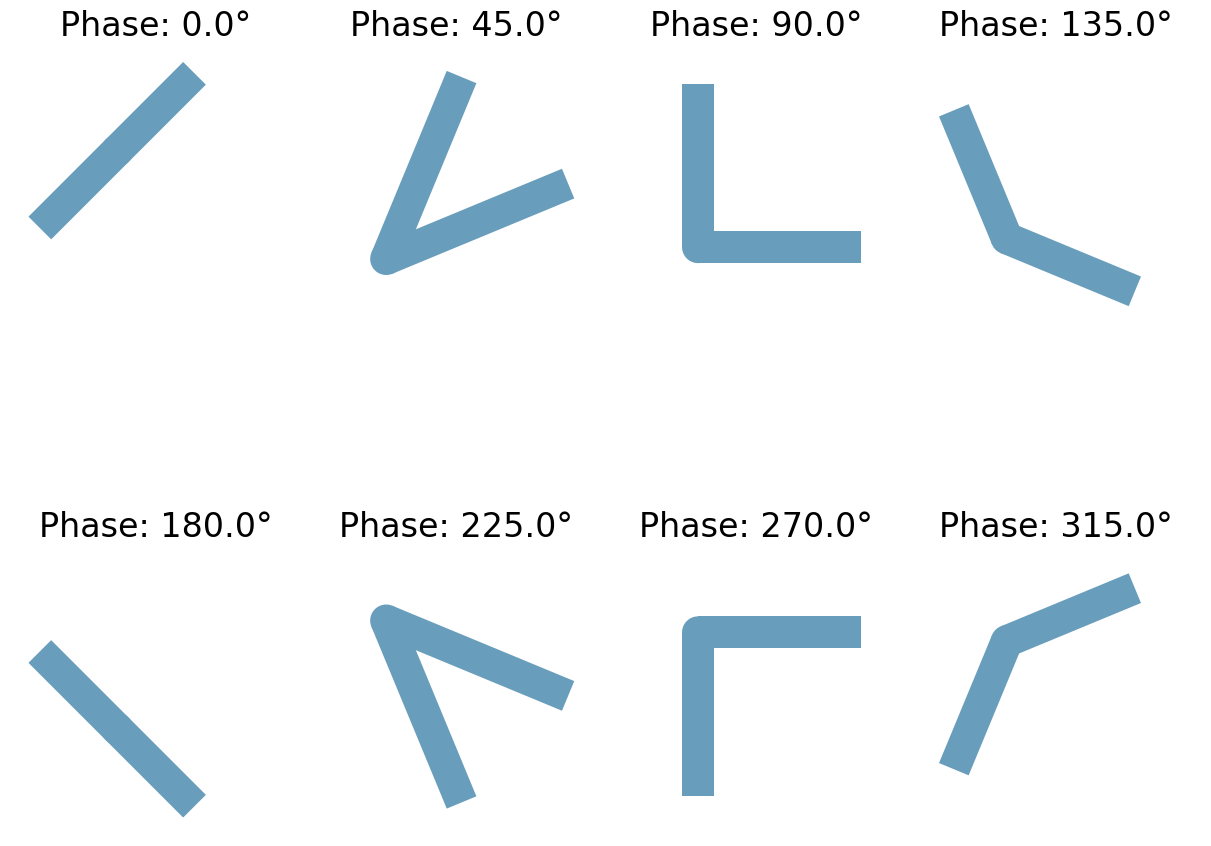

In [6]:
simulations = {}
fig, axes = plt.subplots(2, 4, figsize=(12, 10), constrained_layout=True)

for key, ax in zip(range(8), axes.flatten()):
    delta, theta, length = dic_numerator[key]
    antenna = v_antenna(
        center=(0, 0, structure_z_position),
        radius=cylinder_radius,
        length=length,
        delta=delta,
        theta=theta,
    )

    name = f"ScatteringCylinder_{key}"
    simulations[name] = sim.updated_copy(structures=antenna + [substrate])

    # Plot the simulation with monitor_alpha=0 and source_alpha=0
    simulations[name].plot(z=structure_z_position, ax=ax, monitor_alpha=0, source_alpha=0)

    # Calculate the phase applied by the antenna (example calculation)
    applied_phase = key * (np.pi / 4)  # Assuming phase steps of π/4
    applied_phase_deg = np.degrees(applied_phase)  # Convert to degrees

    # Set the title with the phase
    ax.set_title(f"Phase: {applied_phase_deg:.1f}°", fontsize=24)

    # Remove axis labels and ticks
    ax.axis("off")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

# Show the figure
plt.show()

Before running the simulation, we can visualize the setup to ensure everything is correctly placed.

In [7]:
simulations["ScatteringCylinder_0"].plot_3d()

### Running the `Batch` Simulation

Now we create and run a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) simulation, which executes the eight simulations in parallel.

In [8]:
# Creating the batch object
batch = web.Batch(simulations=simulations, verbose=True)

# Running the batch
results = batch.run(path_dir="dataScatteringCylinders")

Output()

14:54:43 -03 Started working on Batch containing 8 tasks.

14:54:51 -03 Maximum FlexCredit cost: 1.575 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:54:57 -03 Batch complete.

Output()

### Visualizing Scattered Amplitude and Phase

First, we visualize the *Ey* field component and its phase.  

Since the fields are complex values, the phase can be easily calculated using the [`np.angle`](https://numpy.org/devdocs/reference/generated/numpy.angle.html) function.

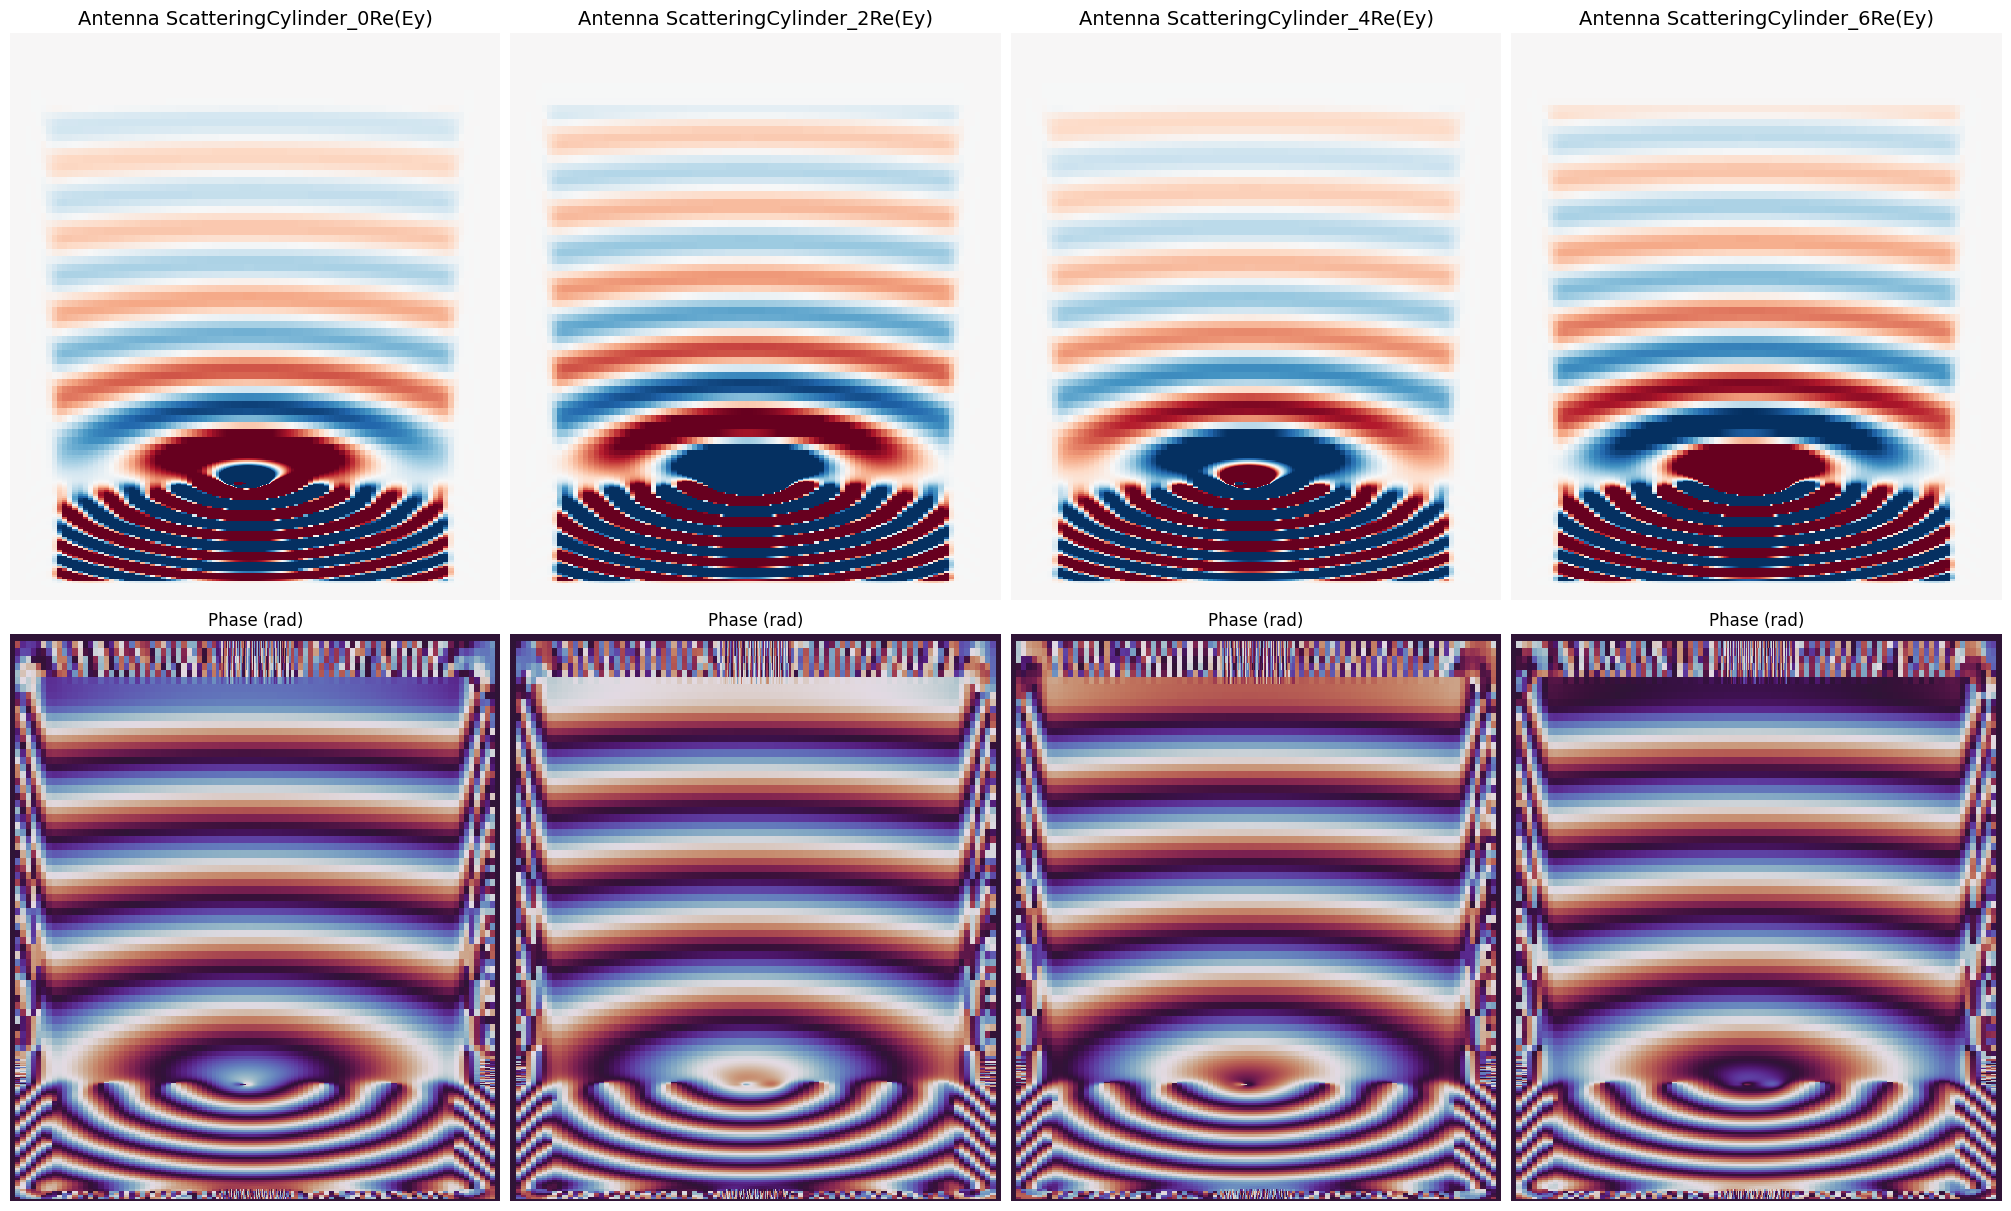

In [9]:
# Plotting the scattered fields and phases
N = len(simulations)
fig, axes = plt.subplots(2, int(N / 2), figsize=(5 * int(N / 2), 12), constrained_layout=True)
keys = list(simulations.keys())
for col, i in enumerate(range(0, N, 2)):
    key = keys[i]
    result = results[key]
    field = result["field_mon_y"].Ey.squeeze()
    x = result["field_mon_y"].Ey.x.squeeze()
    z = result["field_mon_y"].Ey.z.squeeze()

    amplitude = field.real.T
    phase = np.angle(field).T

    axes[0, col].pcolormesh(x, z, amplitude, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
    axes[0, col].set_title(f"Antenna {key}Re(Ey)", fontsize=14)
    axes[0, col].axis("off")

    axes[1, col].pcolormesh(x, z, phase, vmin=-np.pi, vmax=np.pi, cmap="twilight")
    axes[1, col].set_title("Phase (rad)", fontsize=12)
    axes[1, col].axis("off")

As we can see, the phase of the transmitted fields increases across different antennas.

### Extracting On-Axis Phase Delays

We probe the center of the `field_mon_y` plane, compute the complex phase, and reference everything to antenna 0.

It can be observed that the antennas provide a continuous phase variation over 360 degrees.

In [10]:
# Collect phase at monitor intersection for each antenna
phases = []
for name in simulations:
    monitor = results[name]["field_mon_y"]
    value = monitor.Ey.sel(z=20, method="nearest").squeeze()
    phases.append(np.angle(np.mean(value.data)))

phases = np.array(phases)

Phase shift summary (deg):
  ScatteringCylinder_0: -0.00
  ScatteringCylinder_1: 38.03
  ScatteringCylinder_2: 107.05
  ScatteringCylinder_3: 162.07
  ScatteringCylinder_4: 180.00
  ScatteringCylinder_5: 218.03
  ScatteringCylinder_6: 287.05
  ScatteringCylinder_7: 342.07


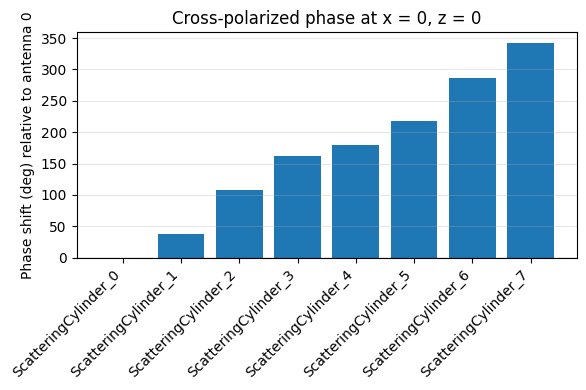

In [11]:
# Reference all phases to antenna 0
phase_deg = -np.degrees(np.unwrap(phases - phases[0]))

# Bar chart summarizing relative phase at z = 0
fig, ax = plt.subplots(figsize=(6, 4))
indices = np.arange(len(phase_deg))
ax.bar(indices, phase_deg)
ax.set_xticks(indices)
ax.set_xticklabels(list(simulations.keys()), rotation=45, ha="right")
ax.set_ylabel("Phase shift (deg) relative to antenna 0")
ax.set_title("Cross-polarized phase at x = 0, z = 0")
ax.axhline(0, color="k", linewidth=0.8)
ax.grid(True, axis="y", alpha=0.3)
fig.tight_layout()

# Tabulate numeric values for quick inspection
print("Phase shift summary (deg):")
for name, value in zip(simulations.keys(), phase_deg):
    print(f"  {name}: {value:.2f}")

## Phase calculation using a [DiffractionMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DiffractionMonitor.html) and periodic boundary conditions

Now, we can adapt the simulations from the previous section to use periodic boundaries and replace the [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) with a [DiffractionMonitor]. We will also replace the [TFSF](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.TFSF.html) source with a [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) source.

With this approach, we can also reduce the simulation size in the z-direction.

In [12]:
# Define boundary conditions: periodic in x and y, PML absorbing boundaries in z
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
)

# Set simulation domain center and size for periodic setup
sim_periodic_center = (0, 0, structure_z_position)
sim_periodic_size = (sx, sy, 2 * wl)

# Create a diffraction monitor above the structure to capture transmitted/reflected fields
diffraction_monitor = td.DiffractionMonitor(
    center=(0, 0, structure_z_position + wl - 1),
    size=(td.inf, td.inf, 0),
    freqs=[fcen],
    name="diffraction_monitor",
)

# Define a plane wave source below the structure
pw_source = td.PlaneWave(
    center=(0, 0, structure_z_position - wl + 1),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=fcen, fwidth=fwidth),
    name="pw_source",
    direction="+",
)

# Creating the simulation dictionary for the Batch
sims_periodic = {
    i: simulations[i].updated_copy(
        boundary_spec=boundary_spec,
        monitors=[diffraction_monitor],
        sources=[pw_source],
        size=sim_periodic_size,
        center=sim_periodic_center,
    )
    for i in simulations.keys()
}

In [13]:
# Visualizing the setup
sims_periodic["ScatteringCylinder_0"].plot_3d()

In [14]:
# Running the Batch

batch_periodic = web.Batch(simulations=sims_periodic, verbose=True)
results_periodic = batch_periodic.run(path_dir="dataScatteringCylindersPeriodic")

Output()

14:55:55 -03 Started working on Batch containing 8 tasks.

14:56:03 -03 Maximum FlexCredit cost: 0.969 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:56:36 -03 Batch complete.

Output()

Now, we can analyze the amplitude of the first diffraction order of the cross-polarized component and again use `np.angle` to extract the phase. 

As we can see, the results match very well with those from the previous setup.

In [15]:
phase_s = []
phase_p = []

for k in results_periodic.keys():
    sim_data_periodic = results_periodic[k]
    diffraction_data = sim_data_periodic["diffraction_monitor"]
    phase_s.append(np.angle(diffraction_data.amps.sel(orders_x=0, orders_y=0, polarization="s"))[0])

Phase shift summary (deg) - periodic:
  ScatteringCylinder_0: -0.00
  ScatteringCylinder_1: 37.99
  ScatteringCylinder_2: 107.35
  ScatteringCylinder_3: 162.19
  ScatteringCylinder_4: 180.00
  ScatteringCylinder_5: 217.99
  ScatteringCylinder_6: 287.35
  ScatteringCylinder_7: 342.19


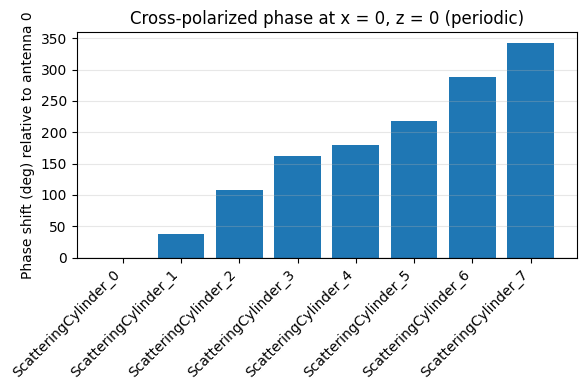

In [16]:
phase_s = np.array(phase_s)

# Reference all phases to antenna 0
phase_deg_periodic = -np.degrees(np.unwrap(phase_s - phase_s[0]))

# Bar chart summarizing relative phase at z = 0
fig_periodic, ax_periodic = plt.subplots(figsize=(6, 4))
indices_periodic = np.arange(len(phase_deg_periodic))
ax_periodic.bar(indices_periodic, phase_deg_periodic)
ax_periodic.set_xticks(indices_periodic)
ax_periodic.set_xticklabels(list(sims_periodic.keys()), rotation=45, ha="right")
ax_periodic.set_ylabel("Phase shift (deg) relative to antenna 0")
ax_periodic.set_title("Cross-polarized phase at x = 0, z = 0 (periodic)")
ax_periodic.axhline(0, color="k", linewidth=0.8)
ax_periodic.grid(True, axis="y", alpha=0.3)
fig_periodic.tight_layout()

# Tabulate numeric values for quick inspection
print("Phase shift summary (deg) - periodic:")
for name, value in zip(sims_periodic.keys(), phase_deg_periodic):
    print(f"  {name}: {value:.2f}")